In [77]:
from itertools import product
from typing import List
from operator import attrgetter

import gym
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (20, 10)

In [78]:
%load_ext autoreload
%autoreload 2

from rl_learning import SimplePolicy, MonetCarloSimulation, QTableDict, QLearningSimulation, EpsilonGreedyPolicy, Sarsa
from notebook_util import make_grid, TDLearningRes, heatmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Часть первая

## Простая стратегия

In [79]:
policy = SimplePolicy()
simulator = MonetCarloSimulation(gym.make("Blackjack-v0"), policy)

In [80]:
rewards = simulator.simulate(10_000)

100%|██████████| 10000/10000 [00:01<00:00, 7246.39it/s]


In [81]:
rows = []
for state, expected_reward in rewards.items():
    rows.append(state + (expected_reward,))

In [82]:
stat = pd.DataFrame(rows, columns=["player_sum", "dealer_open_card", "usable_ace", "reward"])

In [83]:
usable_ace_stat = stat[stat["usable_ace"] == True]
not_usable_ace_stat = stat[stat["usable_ace"] == False]

In [88]:
def plot_v_function(data, title):
    fig = plt.figure()
    ax = fig.add_subplot()

    player_axis_start = 2
    dealer_axis_start = 1
    player_sum = np.arange(player_axis_start, 21 + 2)
    dealer_show = np.arange(dealer_axis_start, 10 + 2)

    _, _, rewards_data = make_grid(player_sum, dealer_show, data["player_sum"].to_numpy(), data["dealer_open_card"].to_numpy(), data["reward"].to_numpy())
    
    heatmap(rewards_data, row_labels=list(map(str, dealer_show)), col_labels=list(map(str, player_sum)), ax=ax, cmap="rainbow")

    ax.set_xlabel("Сумма карт игрока")
    ax.set_ylabel("Открытая карта диллера")
    ax.set_title(title)

    return fig

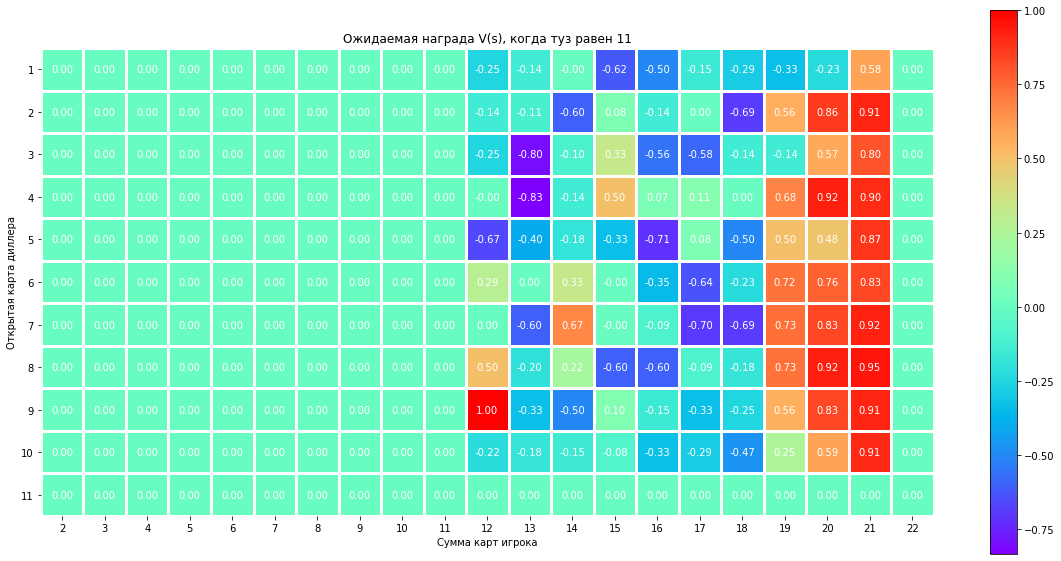

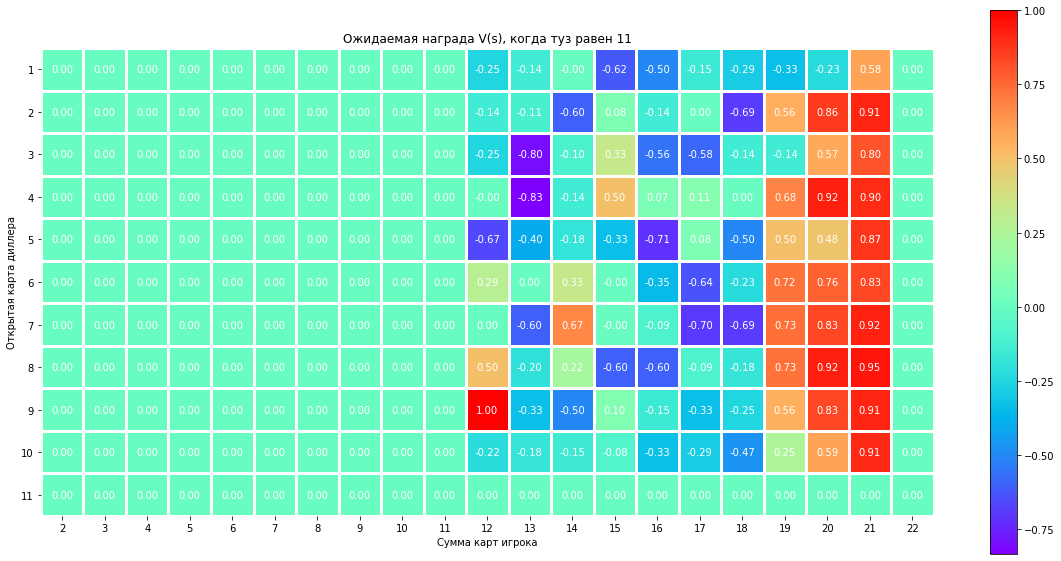

In [89]:
plot_v_function(usable_ace_stat, "Ожидаемая награда V(s), когда туз равен 11")

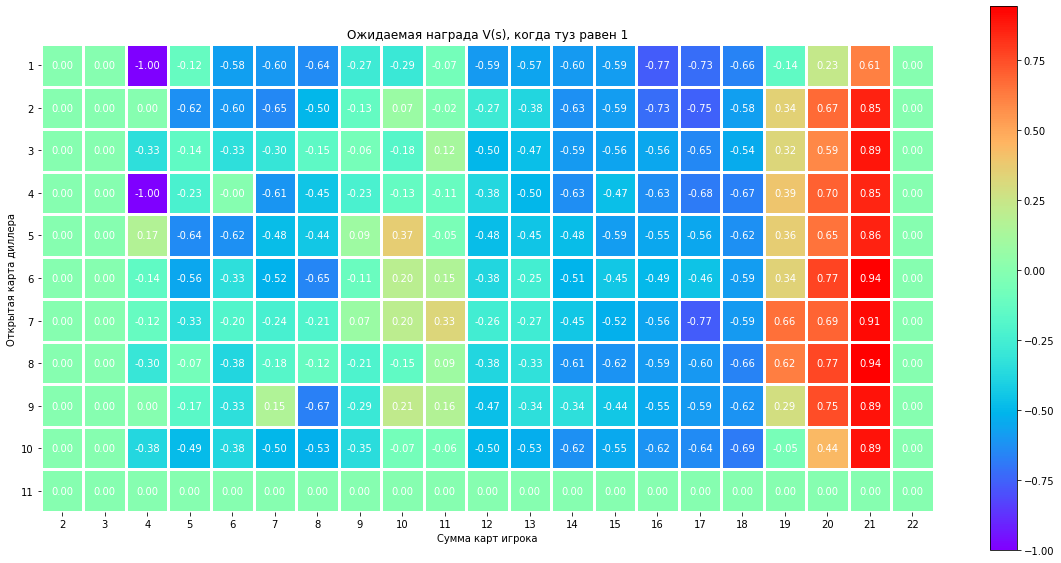

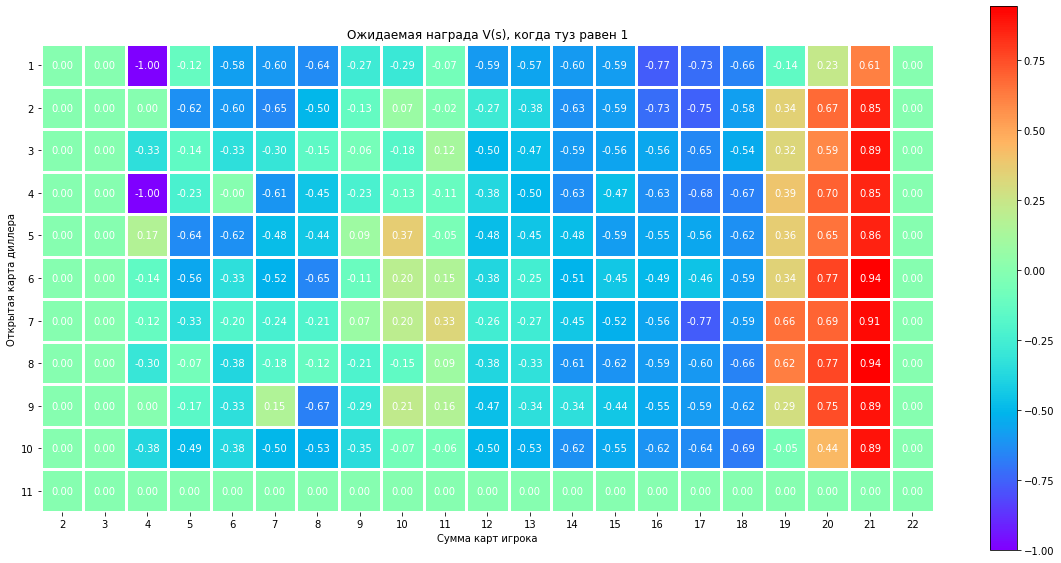

In [90]:
plot_v_function(not_usable_ace_stat, "Ожидаемая награда V(s), когда туз равен 1")

## Q-обучение

In [91]:
def generate_stat(td_learning_cls, gammas, alpha, total_episodes: int, total_test_episodes: int, q_function, policy, is_learning: bool):
    values = []
    for gamma_param, alpha in product(gammas, alpha):
        td_learning = td_learning_cls(gym.make("Blackjack-v0"), policy, q_function, alpha=alpha, gamma=gamma_param, is_learning=is_learning)
        td_res = td_learning.simulate(total_episodes, total_test_episodes)
        values.append(TDLearningRes(alpha, gamma_param, td_res.mean_reward, td_res.mean_step, td_res.test_mean_rewards))
    return values

In [92]:
def plot_td_learning_stat(alpha_axis, gamma_axis, results: List[TDLearningRes], title: str):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    alphas = np.array(list(map(attrgetter("alpha"), results)))
    gammas = np.array(list(map(attrgetter("gamma"), results)))
    mean_rewards = np.array(list(map(attrgetter("mean_reward"), results)))
    
    _, _, mean_reward = make_grid(alpha_axis, gamma_axis, alphas, gammas, mean_rewards)

    heatmap(mean_reward, row_labels=list(map(lambda x: f"{x:.2f}", gamma_axis)), col_labels=list(map(str, alpha_axis)), ax=ax)
    
    ax.set_xlabel("Скорость обучения alpha")
    ax.set_ylabel("gamma")
    ax.set_title(title)

    return fig

In [93]:
def plot_training_process(rewards):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(tuple(range(len(rewards))), rewards)
    ax.set_title("Средняя награда во время обучения")
    ax.set_xlabel("Номер эпизода")
    ax.set_ylabel("Средняя награда")

    return fig

In [94]:
def evaluate_td_learning(alpha_values, gamma_values, epsilon: float, num_train_episodes: int, num_test_episodes: int):
    q_function = QTableDict()
    policy = EpsilonGreedyPolicy(q_function, epsilon=epsilon)

    train_stat = generate_stat(QLearningSimulation, gamma_values, alpha_values, num_train_episodes, num_test_episodes, q_function, policy, is_learning=True)

    train_fig = plot_td_learning_stat(alpha_values, gamma_values, train_stat, "Средняя награда во время обучения")

    best_stat = max(train_stat, key=lambda x: x.mean_reward)
    
    training_fig = plot_training_process(best_stat.test_mean_rewards)
    
    policy = EpsilonGreedyPolicy(q_function, epsilon=0)

    test_stat = generate_stat(QLearningSimulation, gamma_values, alpha_values, num_train_episodes, None, q_function, policy, is_learning=False)

    test_fig = plot_td_learning_stat(alpha_values, gamma_values, test_stat, "Средняя награда при использовании обученной стратегии")

    best_stat = max(test_stat, key=lambda x: x.mean_reward)
    
    return train_fig, test_fig, training_fig

In [100]:
gama_values = np.linspace(0.5, 1, 4)
alpha_values = np.linspace(1e-2, 0.5, 3)
num_train_episodes = 2_000
num_test_episodes = 100

In [101]:
alpha_values

array([0.01 , 0.255, 0.5  ])

100%|██████████| 2000/2000 [00:00<00:00, 9756.38it/s] 


(<Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 1 Axes>)

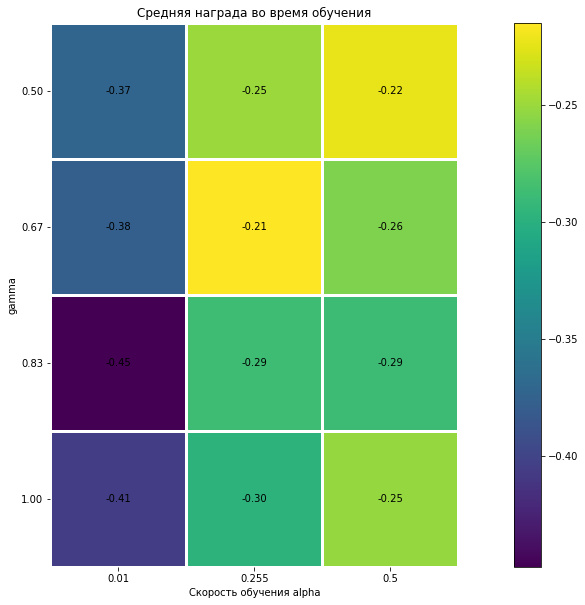

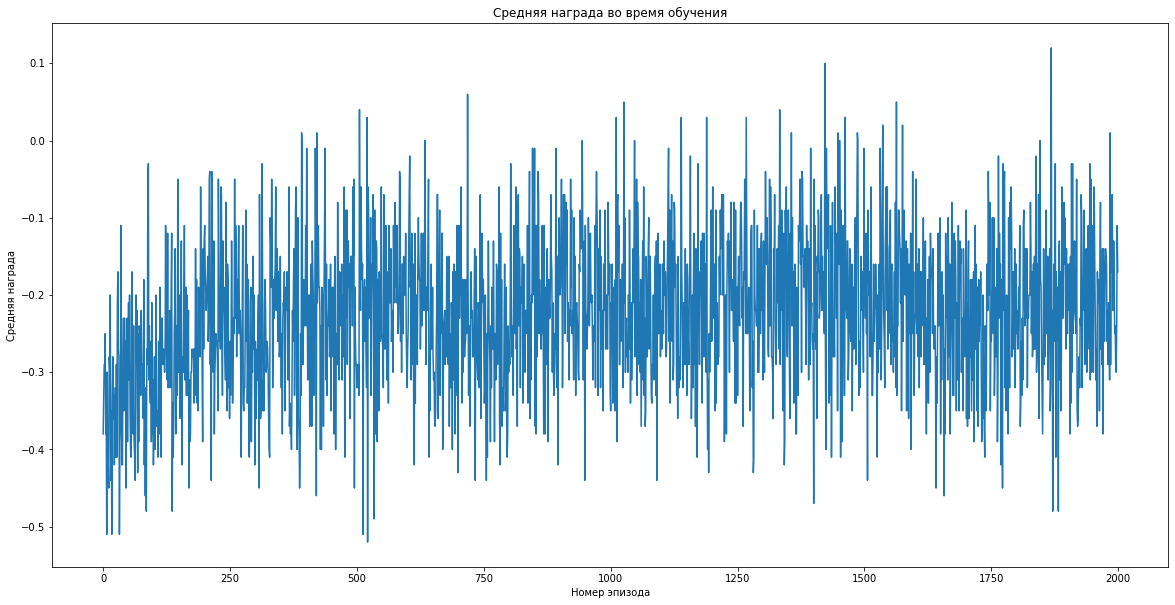

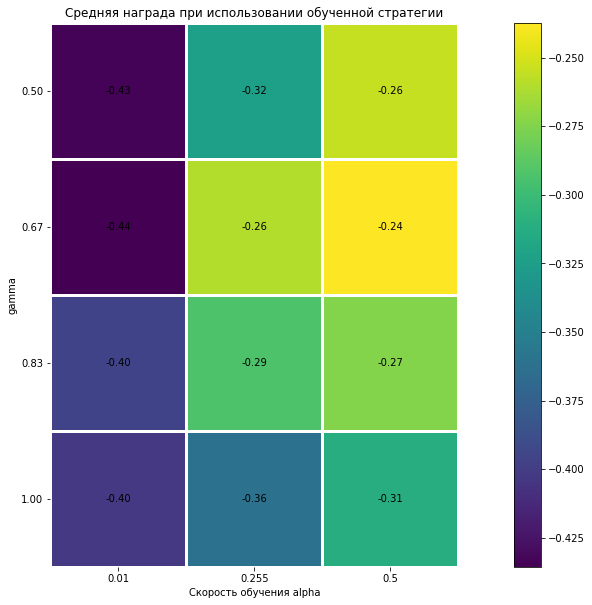

In [102]:
evaluate_td_learning(alpha_values, gama_values, epsilon=0.01, num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes)

# Sarsa

In [18]:
values = np.array(generate_params_params(Sarsa, gama, num_runs))

NameError: name 'generate_params_params' is not defined

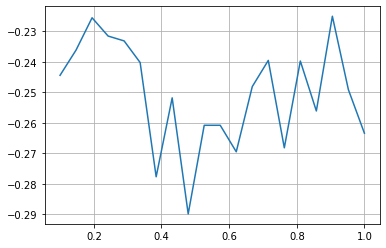

In [ ]:
plt.plot(values[:, 0], values[:, 1])
plt.grid(True)